In [ ]:
# !pip install opendatasets

In [ ]:
# import opendatasets as od

# od.download("https://www.kaggle.com/datasets/laurentmih/aisegmentcom-matting-human-datasets")


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import keras
from keras import layers
from PIL import Image
from IPython.core.display import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.image import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
def masking(x):
  return np.where( x > 0, 1.0, 0.0)

In [5]:
seed = 1
image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen  = ImageDataGenerator(preprocessing_function=masking)
train_image_generator = image_datagen.flow_from_directory(
    '/content/drive/MyDrive/aisegmentcom-matting-human-datasets/clip_img/train',
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    seed=seed)
train_mask_generator = mask_datagen.flow_from_directory(
    '/content/drive/MyDrive/aisegmentcom-matting-human-datasets/matting/train',
    color_mode='grayscale',
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(train_image_generator, train_mask_generator)

Found 10383 images belonging to 24 classes.
Found 10383 images belonging to 24 classes.
Found 163 images belonging to 1 classes.
Found 95 images belonging to 1 classes.


##**U Net Arc.**

In [ ]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [ ]:
def build_unet_model():
   inputs = layers.Input(shape=(256,256,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 16)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 32)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 64)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 128)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 256)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 128)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 64)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 32)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 16)
   # outputs
   outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)
   # unet model with Keras Functional API
   unet_model = keras.Model(inputs, outputs, name="U-Net")

   return unet_model


unet_model = build_unet_model()
unet_model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy)

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
history = unet_model.fit(train_generator, epochs=10, steps_per_epoch=1000)

Epoch 1/10
1000/1000 [==============================] - 307s 283ms/step - loss: 0.2368
Epoch 2/10
1000/1000 [==============================] - 283s 283ms/step - loss: 0.1625
Epoch 3/10
1000/1000 [==============================] - 278s 278ms/step - loss: 0.1468
Epoch 4/10
1000/1000 [==============================] - 271s 271ms/step - loss: 0.1396
Epoch 5/10
1000/1000 [==============================] - 282s 282ms/step - loss: 0.1360
Epoch 6/10
1000/1000 [==============================] - 279s 279ms/step - loss: 0.1316
Epoch 7/10
1000/1000 [==============================] - 276s 276ms/step - loss: 0.1284
Epoch 8/10
1000/1000 [==============================] - 276s 276ms/step - loss: 0.1260
Epoch 9/10
1000/1000 [==============================] - 282s 282ms/step - loss: 0.1223
Epoch 10/10
1000/1000 [==============================] - 278s 278ms/step - loss: 0.1206


In [6]:
def load_data(path_X, path_y, max=20):
    X = list()
    y = list()
    i = 0
    # iterate over files in
    # that directory
    folders_X = Path(path_X).glob('*')
    folders_y = Path(path_y).glob('*')
    for folder_X,  folder_y in zip(folders_X, folders_y):
      files_X = Path(folder_X).glob('*')
      files_y = Path(folder_y).glob('*')
      for file_X, file_y in zip(files_X, files_y):
        i+=1
        if i == max:
          break

        im_X = resize(img_to_array(load_img(file_X))/255., (256, 256)).numpy()
        im_y = resize(img_to_array(load_img(file_y))/255., (256, 256)).numpy()

        if len(im_X.shape) == 3:
          if im_X.shape[2] == 3:
            X.append(im_X)
            y.append(im_y)

      if i == max:
          break
    return np.array(X), np.array(y)
x_test, y_test = load_data('/content/drive/MyDrive/aisegmentcom-matting-human-datasets/clip_img/test', '/content/drive/MyDrive/aisegmentcom-matting-human-datasets/matting/test')

In [7]:
unet_model = keras.models.load_model('/content/drive/MyDrive/aisegmentcom-matting-human-datasets/BG_Removal.h5')

In [8]:
masks = unet_model.predict(x_test)

1/1 [==============================] - 11s 11s/step


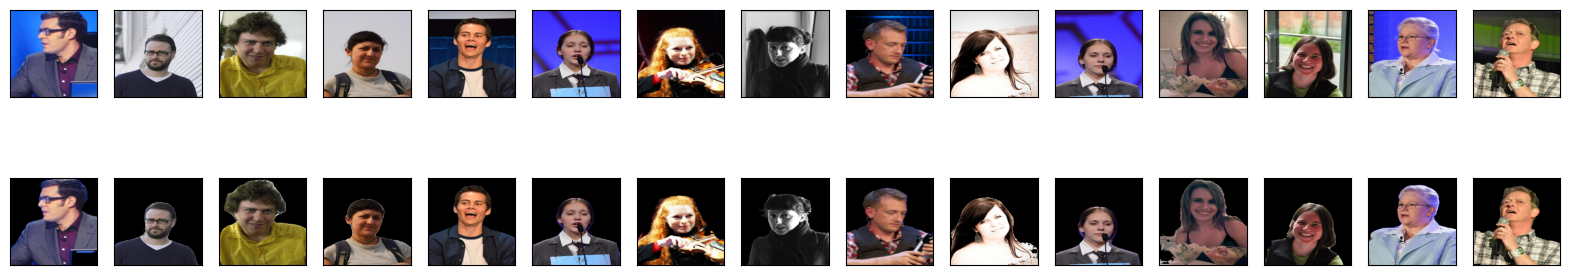

In [16]:
import matplotlib.pyplot as plt

n = 15
plt.figure(figsize=(20, 4))
for i in range(0, n ):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n + 1 )
    plt.imshow(np.where(masks[i]>0.5, x_test[i], 0.0), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
unet_model.save('/content/drive/MyDrive/aisegmentcom-matting-human-datasets/BG_Removal.h5')

##**Inference**

In [33]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 10.5 MB/s eta 

In [35]:
import gradio as gr
from keras.preprocessing import image

unet_model = keras.models.load_model('/content/drive/MyDrive/aisegmentcom-matting-human-datasets/BG_Removal.h5')

def BG_Removal(input_image):
    # Load and preprocess the input image
    size = input_image.size
    img = input_image.resize(size=(256, 256))
    im = np.array(img) / 255.0
    img = np.expand_dims(im, axis=0)

    output = unet_model.predict(img)[0]
    output = np.where(output>0.5, im, 0.0)
    output = np.array(Image.fromarray((output*255).astype(np.uint8)).resize(size))
    return output

title = "Background Removal"

# Create the Gradio interface
inputs = gr.inputs.Image(type='pil')
outputs = gr.outputs.Image(type='numpy')
interface = gr.Interface(fn=BG_Removal, inputs=inputs, outputs=outputs, title=title)

interface.launch(share=True, debug=True)


<ipython-input-35-dee570812aff>:21: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs = gr.inputs.Image(type='pil')
<ipython-input-35-dee570812aff>:21: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs = gr.inputs.Image(type='pil')
<ipython-input-35-dee570812aff>:22: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  outputs = gr.outputs.Image(type='numpy')


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://8e97ac68ab7ecd8e21.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 237ms/step


/usr/local/lib/python3.10/dist-packages/gradio/components/button.py:89: UserWarning: Using the update method is deprecated. Simply return a new object instead, e.g. `return gr.Button(...)` instead of `return gr.Button.update(...)`.
  warnings.warn(


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8e97ac68ab7ecd8e21.gradio.live
